# LSTM with Pytorch

## Stock: `SBUX`, LSTM Example
Code taken from: <a href="https://cnvrg.io/pytorch-lstm/">here</a>
Predicting Volume from Open, High, Low, Close, Adj Close

In [128]:
import numpy as np
import pandas as pd
df = pd.read_csv('Financial_News/SBUX.csv', index_col = 'Date', parse_dates=True)
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,83.039520,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,84.593086,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,85.034225,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,85.139709,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,84.516373,7296900


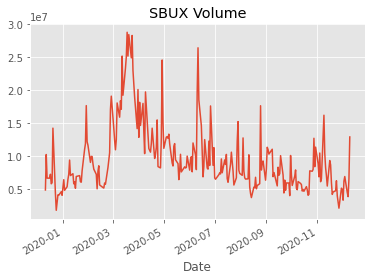

In [145]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
df['Volume'].plot(label='Volume', title='SBUX Volume')
plt.show()

In [130]:
#X = df_nvda.loc[:, ['Positive', 'Negative', 'Neutral']]

X = df.iloc[:, :-1]
y = df.iloc[:, 5:6]
X

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,83.039520
2019-12-12,88.000000,88.889999,87.540001,88.209999,84.593086
2019-12-13,88.019997,88.790001,87.580002,88.669998,85.034225
2019-12-16,89.139999,89.300003,88.430000,88.779999,85.139709
2019-12-17,88.870003,88.970001,87.470001,88.129997,84.516373
...,...,...,...,...,...
2020-12-04,101.349998,102.940002,101.070000,102.279999,100.109154
2020-12-07,102.010002,102.220001,100.690002,101.410004,99.257629
2020-12-08,100.370003,101.570000,100.010002,101.209999,99.061859


In [131]:
#y = df_nvda.loc[:, 'Close']
y

,Volume
Date,
2019-12-11,4921900
2019-12-12,10282100
2019-12-13,6714100
2019-12-16,6705600
2019-12-17,7296900
...,...
2020-12-04,6952700
2020-12-07,4514800
2020-12-08,3911300


In [132]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(np.array(y).reshape(-1, 1))

In [133]:
#train - test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.25, shuffle=True)
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (189, 5) (189, 1)
Testing Shape (64, 5) (64, 1)


In [134]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

In [135]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

In [136]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([189, 1, 5]) torch.Size([189, 1])
Testing Shape torch.Size([64, 1, 5]) torch.Size([64, 1])


In [137]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [138]:
#hyperparameters
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [139]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [140]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [141]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.17832
Epoch: 100, loss: 0.02713
Epoch: 200, loss: 0.01691
Epoch: 300, loss: 0.01592
Epoch: 400, loss: 0.01470
Epoch: 500, loss: 0.01314
Epoch: 600, loss: 0.01209
Epoch: 700, loss: 0.01159
Epoch: 800, loss: 0.01096
Epoch: 900, loss: 0.01016


In [142]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

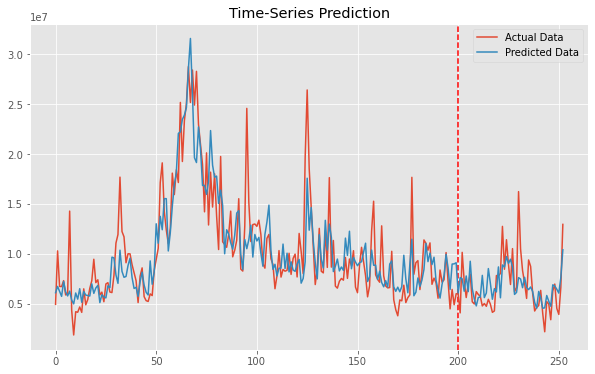

In [143]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## Stock: `Nvidia`, LSTM

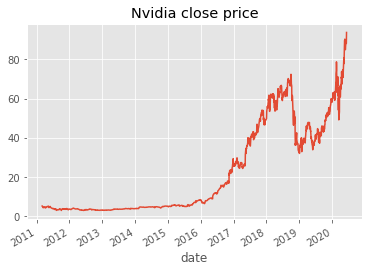

,Unnamed: 0,stock,Open,Close,Volume,Positive,Negative,Neutral,Price_change
date,,,,,,,,,
2011-03-03,1289,NVDA,5.3075,5.2175,159370400,0.015090,0.825096,0.159814,1
2011-03-07,1290,NVDA,5.2275,5.1175,101914000,0.064805,0.025756,0.909439,-1
2011-03-08,1291,NVDA,5.1725,4.8875,194718400,0.331308,0.294181,0.374511,-1
2011-03-09,1292,NVDA,4.8725,4.7850,131897600,0.060045,0.017414,0.922541,-1
2011-03-10,1293,NVDA,4.6750,4.4800,172273600,0.070367,0.041462,0.888172,-1


In [159]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv('Datasets/8_comps_2_labels.csv', index_col = 'date', parse_dates=True)
df = df[df['stock'] == 'NVDA']

plt.style.use('ggplot')
df['Close'].plot(label='Close', title='Nvidia close price')
plt.show()
df.head(5)

In [160]:
X = df.loc[:, ['Open', 'Volume']]
y = df.loc[:, 'Close']

X,y

(                 Open     Volume
 date                            
 2011-03-03   5.307500  159370400
 2011-03-07   5.227500  101914000
 2011-03-08   5.172500  194718400
 2011-03-09   4.872500  131897600
 2011-03-10   4.675000  172273600
 ...               ...        ...
 2020-05-28  84.122498   73489600
 2020-06-02  87.962502   39132000
 2020-06-08  88.772499   38773600
 2020-06-09  88.000000   46848800
 2020-06-10  91.677498   63218000
 
 [1122 rows x 2 columns],
 date
 2011-03-03     5.217500
 2011-03-07     5.117500
 2011-03-08     4.887500
 2011-03-09     4.785000
 2011-03-10     4.480000
                 ...    
 2020-05-28    84.870003
 2020-06-02    88.252502
 2020-06-08    88.050003
 2020-06-09    90.459999
 2020-06-10    93.667503
 Name: Close, Length: 1122, dtype: float64)

In [161]:
# transform features with standard scaler, and output values (close prices) to [0,1] with minmax scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(np.array(y).reshape(-1, 1))

#train - test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.25, shuffle=True)
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)


import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape (841, 2) (841, 1)
Testing Shape (281, 2) (281, 1)
Training Shape torch.Size([841, 1, 2]) torch.Size([841, 1])
Testing Shape torch.Size([281, 1, 2]) torch.Size([281, 1])


In [167]:
#hyperparameters
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 2 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

lstm2 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [171]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm2.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  outputs = lstm2.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.15720
Epoch: 100, loss: 0.07032
Epoch: 200, loss: 0.06866
Epoch: 300, loss: 0.00486
Epoch: 400, loss: 0.00276
Epoch: 500, loss: 0.00182
Epoch: 600, loss: 0.00114
Epoch: 700, loss: 0.00051
Epoch: 800, loss: 0.00028
Epoch: 900, loss: 0.00019


In [177]:
df_X_ss = ss.transform(df.loc[:, ['Open', 'Volume']]) #old transformers
df_y_mm = mm.transform(df.loc[:, ['Close']]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

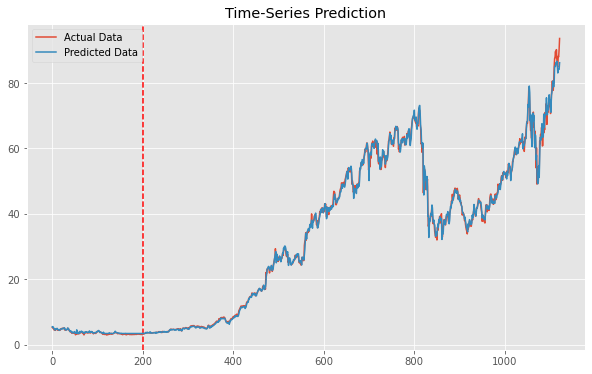

In [179]:
train_predict = lstm2(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## Binary classification -- we need a sigmoid in the end

In [262]:
# with sigmoid at the end
class LSTM2(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM2, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        #extra tanh output layer
        out = self.tanh(out)
        return out

Training Shape (841, 3) (841, 1)
Testing Shape (281, 3) (281, 1)
Training Shape torch.Size([841, 1, 3]) torch.Size([841, 1])
Testing Shape torch.Size([281, 1, 3]) torch.Size([281, 1])
Epoch: 0, loss: 1.00681
Epoch: 100, loss: 0.95675
Epoch: 200, loss: 0.91931
Epoch: 300, loss: 0.91783
Epoch: 400, loss: 0.91742
Epoch: 500, loss: 0.91718
Epoch: 600, loss: 0.91700
Epoch: 700, loss: 0.91684
Epoch: 800, loss: 0.91665
Epoch: 900, loss: 0.91645


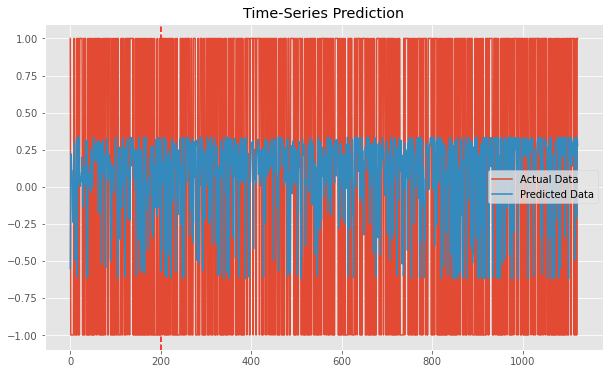

In [263]:
X = df.loc[:, ['Positive', 'Negative', 'Neutral']]
y = df.loc[:, ['Price_change']]

#mm = MinMaxScaler()
#ss = StandardScaler()

X_ss = np.array(X)
y_mm = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.25, shuffle=True)
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

#hyperparameters
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes


lstm3 = LSTM2(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm3.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  outputs = lstm3.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

df_X_ss = df.loc[:, ['Positive', 'Negative', 'Neutral']] #old transformers
df_y_mm = df.loc[:, ['Price_change']] #old transformers

df_X_ss = Variable(torch.Tensor(np.array(df_X_ss))) #converting to Tensors
df_y_mm = Variable(torch.Tensor(np.array(df_y_mm)))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

train_predict = lstm3(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()